In [ ]:
# importacion de librerías
import pandas as pd
import numpy as np
import os as os
import openpyxl as op
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



# IMPORTACIÓN DE DATOS

## Fuentes de los datos:

>la DIAN proporciona información en sus estadisticas sobre Recaudo Bruto por Seccionales y Tipo de Impuesto 2005 - 2025, estos datos están en millones de $COP

>El DANE en su Encuesta Anual Manufacturera recolecta datos de las empresas con el fin de obtener información básica del sector fabril que permita el conocimiento de su estructura, evolución y desarrollo. Utilizaremos esta base de datos para darnos acceso a la información sobre las empresas del sector industrial en particular del pago de impuestos.

## Acceso a datos:
>DIAN: https://www.dian.gov.co/dian/cifras/Paginas/EstadisticasRecaudo.aspx

>DANE: portal micro datos: https://microdatos.dane.gov.co/index.php/catalog/central/about

In [ ]:
# PREPARACIÓN E IMPORTACIÓN DE DATOS DIAN (RECAUDO BRUTO)

# Para Correr el Codigo se puede usar google drive, subiendo los datasets a este
#entorno, o mediante una ruta de ordenador pero en ese caso debe omitir el comando
#de conexión con Google Drive y cambiar la ruta donde están los datasets.

from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


## Importación de dataset de la DIAN:
El objetivo es obtener datos para el intervalo 2018-2023 que estén completos y limpios con una nueva columna llamada departamento que será la que usemos para unir los datos del dane con la DIAN.

In [ ]:
# Ruta base de la carpeta "datasets" (AJUSTAR ESTA RUTA SI ES NECESARIO)
ruta_datasets = r"/content/drive/MyDrive/2025-2/movilidad xternado/IA aplicada/datasets/datasets proyecto"
# Nombre del primer archivo que es tipo xlsx
Recaudo_Bruto = "Estadisticas-de-Recaudo-bruto-por-seccionales-y-tipo-de-impuesto-2005-2025.xlsx"

# creamos ruta para importar el primer archivo
ruta_Recaudo_Bruto = os.path.join(ruta_datasets, Recaudo_Bruto)

# carga del archivo usando la ruta, saltándonos las primeras 5 filas y las últimas 10
df_impuestos = pd.read_excel(ruta_Recaudo_Bruto,  skiprows=5,skipfooter=10)
# al ver el dataframe, notamos que la fila 1 y 2 están fusionadas por lo que debemos eliminar una
df_impuestos=df_impuestos.drop(index=0)

# de otro lado la columna AÑO debe ser rellenada (forward fill)
df_impuestos['AÑO'] = df_impuestos['AÑO'].ffill()

# Ahora bien, vamos a manejar datos solamente de 2018 a 2023, por lo que filtramos el dataframe
df_impuestos['AÑO'] = pd.to_numeric(df_impuestos['AÑO'], errors='coerce')  # Convertir a numérico
df_impuestos = df_impuestos[(df_impuestos['AÑO'] >= 2018) & (df_impuestos['AÑO'] <= 2023)]
df_impuestos['AÑO'] = df_impuestos['AÑO'].astype(int)
df_impuestos.reset_index(inplace=True, drop=True)

# Normalizar los nombres en la columna DIRECCIÓN_SECCIONAL
df_impuestos["DIRECCIÓN SECCIONAL"] = (
    df_impuestos["DIRECCIÓN SECCIONAL"]
    .str.strip()  # elimina espacios antes/después
    .str.upper() ) # pasa todo a mayúsculas

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# CONVERSIÓN DE UNIDADES (Millones a Miles de $COP)


# hay columnas tipo texto asi que vamos a ignorarlas para trabajar sin errores en una conversión de formato.
columnas_excluidas = ['AÑO', 'DIRECCIÓN SECCIONAL']
columnas_a_convertir = df_impuestos.columns.drop(columnas_excluidas)

# conversión solo a esas columnas. Reemplazamos no-números con NaN y luego multiplicamos.
df_impuestos[columnas_a_convertir] = df_impuestos[columnas_a_convertir].apply(pd.to_numeric, errors='coerce')
# Multiplicación para pasar de Millones a Miles (Millones * 1000)
df_impuestos[columnas_a_convertir] = df_impuestos[columnas_a_convertir] * 1000
# convertimos los valores NaN a 0
df_impuestos = df_impuestos.fillna(0)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# MAPPING DE SECCIONALES A DEPARTAMENTO Y CÓDIGO (DIAN

# Diccionario ciudad -> departamento (ajustado a mayúsculas)
ciudades_departamentos = {
    "ADUANAS BARRANQUILLA": "ATLÁNTICO",
    "ADUANAS BOGOTA": "CUNDINAMARCA",
    "ADUANAS CALI": "VALLE DEL CAUCA",
    "ADUANAS CARTAGENA": "BOLÍVAR",
    "ADUANAS DE CUCUTA": "NORTE DE SANTANDER",
    "ADUANAS DE MEDELLIN": "ANTIOQUIA",
    "IMPUESTOS BOGOTA": "CUNDINAMARCA",
    "GRANDES CONTRIBUYENTES BOGOTA": "BOGOTÁ, D.C.",
    "OPERERATIVA DE GRANDES CONTRIBUYENTES": "BOGOTÁ, D.C.",
    "OPERATIVA GRANDES CONTRIBUYENTES": "BOGOTÁ, D.C.",

    "ARAUCA": "ARAUCA",
    "ARMENIA": "QUINDÍO",
    "BARRANCABERMEJA": "SANTANDER",
    "BARRANQUILLA": "ATLÁNTICO",
    "BUCARAMANGA": "SANTANDER",
    "BUENAVENTURA": "VALLE DEL CAUCA",
    "CALI": "VALLE DEL CAUCA",
    "CARTAGENA": "BOLÍVAR",
    "CUCUTA": "NORTE DE SANTANDER",
    "FLORENCIA": "CAQUETÁ",
    "GIRARDOT": "CUNDINAMARCA",
    "IBAGUE": "TOLIMA",
    "INIRIDA": "GUAINÍA",
    "IPIALES": "NARIÑO",
    "LETICIA": "AMAZONAS",
    "MAICAO": "LA GUAJIRA",
    "MANIZALES": "CALDAS",
    "MEDELLIN": "ANTIOQUIA",
    "MITU": "VAUPÉS",
    "MONTERIA": "CÓRDOBA",
    "NEIVA": "HUILA",
    "PALMIRA": "VALLE DEL CAUCA",
    "PASTO": "NARIÑO",
    "PEREIRA": "RISARALDA",
    "POPAYAN": "CAUCA",
    "PUERTO ASIS": "PUTUMAYO",
    "PUERTO CARREÑO": "VICHADA",
    "QUIBDO": "CHOCÓ",
    "RIOHACHA": "LA GUAJIRA",
    "SAN ANDRES": "ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANTA CATALINA",
    "SAN JOSE DEL GUAVIARE": "GUAVIARE",
    "SANTA MARTA": "MAGDALENA",
    "SINCELEJO": "SUCRE",
    "SOGAMOSO": "BOYACÁ",
    "TULUA": "VALLE DEL CAUCA",
    "TUNJA": "BOYACÁ",
    "URABA": "ANTIOQUIA",
    "VALLEDUPAR": "CESAR",
    "VILLAVICENCIO": "META",
    "YOPAL": "CASANARE"
}

# Diccionario departamento -> código
departamento_codigos = {
    "ANTIOQUIA": 5,
    "ATLÁNTICO": 8,
    "BOGOTÁ, D.C.": 11,
    "BOLÍVAR": 13,
    "BOYACÁ": 15,
    "CALDAS": 17,
    "CAQUETÁ": 18,
    "CAUCA": 19,
    "CESAR": 20,
    "CÓRDOBA": 23,
    "CUNDINAMARCA": 25,
    "CHOCÓ": 27,
    "HUILA": 41,
    "LA GUAJIRA": 44,
    "MAGDALENA": 47,
    "META": 50,
    "NARIÑO": 52,
    "NORTE DE SANTANDER": 54,
    "QUINDÍO": 63,
    "RISARALDA": 66,
    "SANTANDER": 68,
    "SUCRE": 70,
    "TOLIMA": 73,
    "VALLE DEL CAUCA": 76,
    "ARAUCA": 81,
    "CASANARE": 85,
    "PUTUMAYO": 86,
    "ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANTA CATALINA": 88,
    "AMAZONAS": 91,
    "GUAINÍA": 94,
    "GUAVIARE": 95,
    "VAUPÉS": 97,
    "VICHADA": 99
}

# eliminación de filas de totales por año
df_impuestos_arreglado = df_impuestos[~df_impuestos["DIRECCIÓN SECCIONAL"].str.contains("TOTAL AÑO", case=False, na=False)].copy()
# Asignación de departamento
df_impuestos_arreglado["departamento"] = df_impuestos_arreglado["DIRECCIÓN SECCIONAL"].map(ciudades_departamentos)

# Asignación de código de departamento
df_impuestos_arreglado["dpto"] = df_impuestos_arreglado["departamento"].map(departamento_codigos)
df_impuestos_arreglado['dpto'] = df_impuestos_arreglado['dpto'].apply(pd.to_numeric, errors='coerce')
df_impuestos_arreglado = df_impuestos_arreglado.dropna(subset=["dpto"])
df_impuestos_arreglado["dpto"] = df_impuestos_arreglado["dpto"].astype(int)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# CONSOLIDACIÓN DIAN POR DPTO Y AÑO

# Agrupar por 'dpto' y 'AÑO' y sumar los valores de recaudo para consolidar
# todas las seccionales (Aduanas, Impuestos, Grandes Contribuyentes) en un
# único total por cada departamento y año.
df_DIAN_consolidado = df_impuestos_arreglado.groupby(['dpto', 'AÑO']).sum(numeric_only=True).reset_index()

# Función para limpiar los nombres de columnas (eliminar espacios no deseados y \xa0)
def clean_col_name(col):
    col = col.replace('\xa0', ' ') # Reemplazar espacio no-breaking con espacio normal
    col = col.strip()             # Eliminar espacios iniciales/finales (incluyendo \n)
    col = ' '.join(col.split())   # Colapsar múltiples espacios internos a uno solo
    return col

# Aplicar la limpieza a los nombres de las columnas del DataFrame de la DIAN
df_DIAN_consolidado.columns = [clean_col_name(col) for col in df_DIAN_consolidado.columns]

# Opcional: limpiar columnas que no son de impuestos después de la suma
columnas_a_mantener_dian = ['dpto', 'AÑO'] + [col for col in df_DIAN_consolidado.columns if col not in ['dpto', 'AÑO', 'DIRECCIÓN SECCIONAL', 'departamento']]
df_DIAN_consolidado = df_DIAN_consolidado[columnas_a_mantener_dian]

In [ ]:
# IMPORTACIÓN Y PROCESAMIENTO DE DATOS EAM (DANE)

# dado que son varios datasets, vamos a hacer un bucle para procesarlos todos de forma
# eficiente. Algo importante es que en la agrupación de la base de datos no queremos
# tomar en cuenta las columnas que no son de impuestos, por lo que haremos un renombramiento
# y una selección previa de las columnas que nos interesan, tampoco vamos a eliminarlas pues
# las necesitaremos para hacer merge de las bases más adelante.

# indicación de la ruta de los datasets y el separador de los archivos csv
# (AJUSTAR ESTA RUTA SI ES NECESARIO)

# receurdese que antes se definió la ruta en "ruta_datasets"
CSV_SEPARATOR = ';'

# Diccionario de configuración de archivos y formato exacto por año
archivos = {
    2018: {'nombre': 'EAM_ANONIMIZADA_2018.csv', 'formato': 'csv'},
    2019: {'nombre': 'EAM_ANONIMIZADA_2019.csv', 'formato': 'csv'},
    2020: {'nombre': 'EAM_ANONIMIZADA_2020.xlsx', 'formato': 'xlsx'},
    2021: {'nombre': 'EAM_ANONIMIZADA_2021.xlsx', 'formato': 'xlsx'},
    2022: {'nombre': 'EAM_ANONIMIZADA_2022.xlsx', 'formato': 'xlsx'},
    2023: {'nombre': 'EAM_ANONIMIZADA_2023.xlsx', 'formato': 'xlsx'}
}

# Diccionario de decodificación y selección de columnas
columnas_renombre = {
    'dpto': 'DEPARTAMENTO',
    'periodo': 'AÑO',
    'C3R20C3': 'Impuesto de Renta para la Equidad',
    'c3r25c3': 'Impuesto del 4 x 1 000',
    'c3r37c3': 'Impuesto de Industria y Comercio',
    'c3r38c3': 'Impuesto Predial y sobre Vehículos'
}
columnas_seleccion = list(columnas_renombre.keys()) # Las columnas originales que buscamos
columnas_impuestos = list(columnas_renombre.values())[2:] # Solo los nombres de los impuestos finales

# Lista para almacenar los DataFrames procesados anualmente
list_df_anuales = []

# Bucle de Procesamiento
for año, dataset in archivos.items():
    nombre_archivo = dataset['nombre']
    formato_archivo = dataset['formato']
    ruta_archivo = os.path.join(ruta_datasets, nombre_archivo)
    df_EAM = None

    # Importación Condicional
    try:
        if formato_archivo == 'xlsx':
            df_EAM = pd.read_excel(ruta_archivo)
        elif formato_archivo == 'csv':
            df_EAM = pd.read_csv(ruta_archivo, sep=CSV_SEPARATOR)
        else:
            print(f" Error: Formato '{formato_archivo}' no reconocido.")
            continue

        # Estandarización de nombres: convierte los nombres de columnas a minúsculas
        df_EAM.columns = df_EAM.columns.str.lower().str.strip()
        print(f"✅ Importado y nombres estandarizados: {nombre_archivo}")

    except FileNotFoundError:
        print(f" Error: Archivo NO encontrado en la ruta para el año {año}.")
        continue
    except Exception as e:
        print(f" Error al leer el archivo {nombre_archivo}. Detalles: {e}")
        continue

    #Selección y Renombramiento
    columnas_a_seleccionar_limpias = [col.lower() for col in columnas_seleccion]

    try:
        # Aquí aplicamos la selección de columnas.
        df_EAM_util = df_EAM[columnas_a_seleccionar_limpias].copy()
    except KeyError as e:
        print(f" ERROR CRÍTICO en el año {año}: Columnas no encontradas. Faltan: {e}. Revisar el archivo.")
        print(f"Columnas disponibles: {df_EAM.columns.tolist()}")
        continue

    # Renombramos usando los nombres limpios como clave
    columnas_renombre_limpio = {k.lower(): v for k, v in columnas_renombre.items()}
    df_EAM_util = df_EAM_util.rename(columns=columnas_renombre_limpio)


    #Convertimos  los datos a numero (Necesario para sumar después de leer CSV/TXT)
    for col in columnas_impuestos:
        df_EAM_util[col] = pd.to_numeric(df_EAM_util[col], errors='coerce')

    # Agrupación y Suma por Departamento
    df_EAM_sumado_por_dpto = df_EAM_util.groupby('DEPARTAMENTO').sum(numeric_only=True).reset_index()

    # hay una columna que se llama año pero en la base de la DIAN se llama AÑO por
    # lo que vamos a crear una nueva columna llamada AÑO y le asignamos el valor del año actual
    df_EAM_sumado_por_dpto['AÑO'] = año

    #Almacenamiento para concatenación
    list_df_anuales.append(df_EAM_sumado_por_dpto)


# --- Consolidación Final EAM ---
# Concatenación vertical (apilamiento) de todos los resúmenes anuales.
df_EAM_consolidado = pd.concat(list_df_anuales, ignore_index=True)
df_EAM_consolidado.rename(columns={'DEPARTAMENTO': 'dpto'}, inplace=True)
print("\n--- PROCESO TERMINADO ---")
print("\nPrimeras filas de la EAM):")
print(df_EAM_consolidado.head(10))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



/tmp/ipython-input-1218700575.py:52: DtypeWarning: Columns (302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363) have mixed types. Specify dtype option on import or set low_memory=False.
  df_EAM = pd.read_csv(ruta_archivo, sep=CSV_SEPARATOR)


✅ Importado y nombres estandarizados: EAM_ANONIMIZADA_2018.csv


/tmp/ipython-input-1218700575.py:52: DtypeWarning: Columns (302) have mixed types. Specify dtype option on import or set low_memory=False.
  df_EAM = pd.read_csv(ruta_archivo, sep=CSV_SEPARATOR)


✅ Importado y nombres estandarizados: EAM_ANONIMIZADA_2019.csv
✅ Importado y nombres estandarizados: EAM_ANONIMIZADA_2020.xlsx
✅ Importado y nombres estandarizados: EAM_ANONIMIZADA_2021.xlsx
✅ Importado y nombres estandarizados: EAM_ANONIMIZADA_2022.xlsx
✅ Importado y nombres estandarizados: EAM_ANONIMIZADA_2023.xlsx

--- PROCESO TERMINADO ---

Primeras filas de la EAM):
   dpto   AÑO  Impuesto de Renta para la Equidad  Impuesto del 4 x 1 000  \
0     5  2018                                0.0             161143552.0   
1     8  2018                                0.0              45410108.0   
2    11  2018                                0.0             147122946.0   
3    13  2018                                0.0              42862190.0   
4    15  2018                                0.0               8914892.0   
5    17  2018                                0.0              55487653.0   
6    19  2018                                0.0              18837358.0   
7    20  2018     

In [ ]:
# CRUCE FINAL DE DATOS

# Usamos df_DIAN_consolidado (el agrupado) y la doble clave ['dpto', 'AÑO']
df_EAM_impuestos = pd.merge(df_EAM_consolidado, df_DIAN_consolidado, on=['dpto', 'AÑO'], how='outer')
df_EAM_impuestos = df_EAM_impuestos.fillna(0)

# Eliminación de columnas vacías.
# con clean_col_name() vamos a limpiar los nombres de las columnas que queremos eliminar.
#luego las eliminamos del dataframe final.
#manteniendo el resto de columnas de EAM y DIAN.

columnas_a_eliminar_sucias = [
    'PRODUCTOS PLÁSTICOS 10/', 'BEBIDAS ULTRA PROCESADAS 11/',
    'PRODUCTOS COMESTIBLES 12/', 'IMPUESTO ESPECIAL PARA EL CATATUMBO14/']

columnas_a_eliminar = [clean_col_name(col) for col in columnas_a_eliminar_sucias]
df_EAM_impuestos = df_EAM_impuestos.drop(columns=columnas_a_eliminar, errors='raise')
# df_EAM_impuestos.to_excel("EAM final.xlsx", index=False)

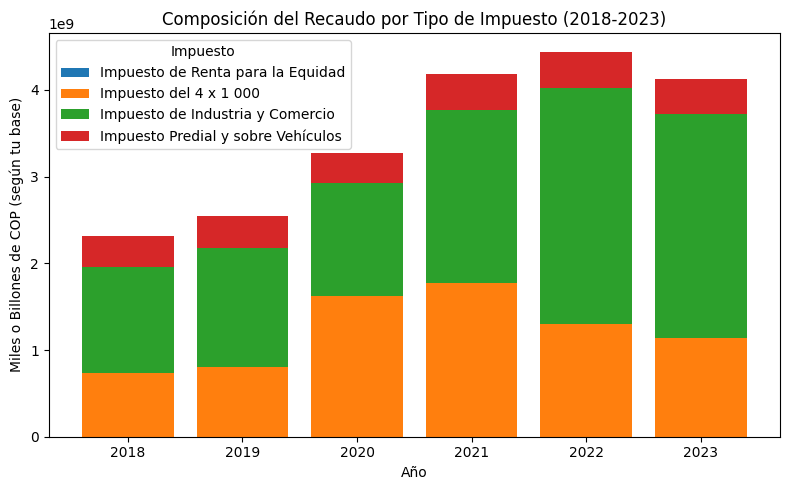

<Figure size 640x480 with 0 Axes>

In [ ]:
# === G R Á F I C O S  F I N A L E S ===
# a continuación, con el fin de hacer una análisis estadístico se realizan
# gráficas que evidencian:
# 1) la composición de los 4 principales impuestos(aquellos de mayor recaudo)
# Barras apiladas por año (composición del recaudo):
df_anual = df_EAM_impuestos.groupby("AÑO")[columnas_impuestos].sum().sort_index()

plt.figure(figsize=(8,5))
bottom = None
for col in columnas_impuestos:
    plt.bar(df_anual.index, df_anual[col],
            bottom=bottom, label=col)
    bottom = df_anual[col] if bottom is None else bottom + df_anual[col]

plt.title("Composición del Recaudo por Tipo de Impuesto (2018-2023)")
plt.xlabel("Año")
plt.ylabel("Miles o Billones de COP (según tu base)")
plt.legend(title="Impuesto")
plt.tight_layout()
plt.show()

fig = plt.gcf()
fig.savefig("Grafico1_Composicion_Recaudo.png", dpi=300, bbox_inches="tight", facecolor="white")



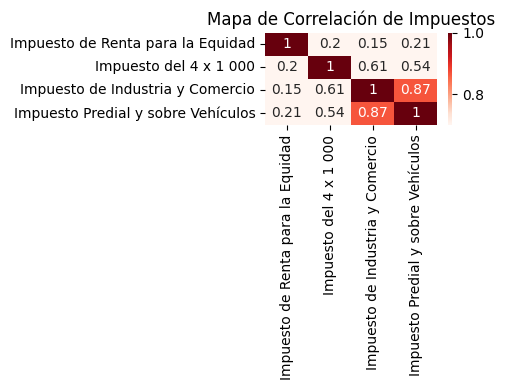

<Figure size 640x480 with 0 Axes>

In [ ]:
# 2)Asociación con mapa de correlación de los impuestos
corr = df_EAM_impuestos[columnas_impuestos].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="Reds", vmin=0.7, vmax=1)
plt.title("Mapa de Correlación de Impuestos")
plt.tight_layout()
plt.show()

fig = plt.gcf()
fig.savefig("Grafico2_Correlacion_Impuestos.png", dpi=300, bbox_inches="tight", facecolor="white")


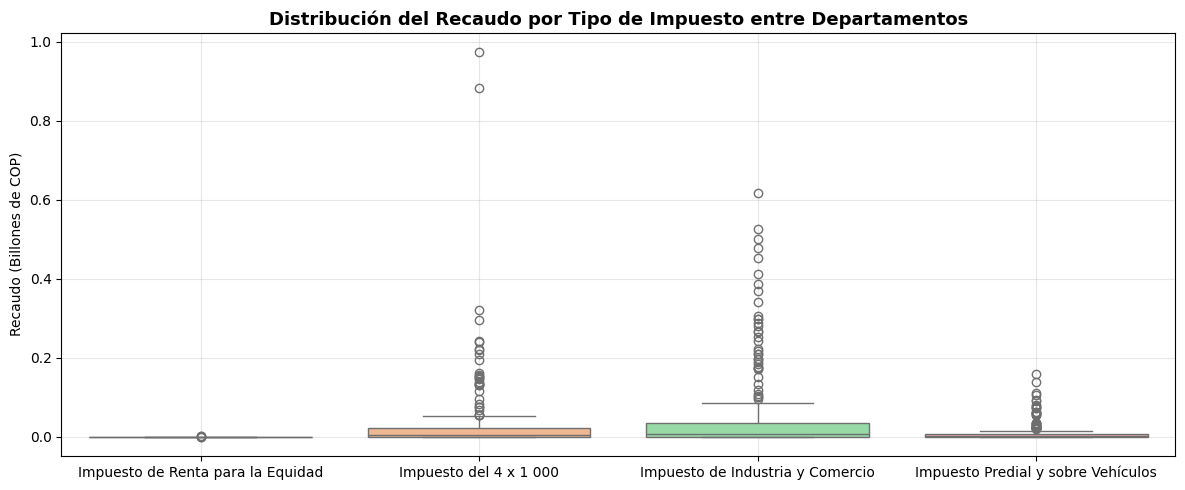

<Figure size 640x480 with 0 Axes>

In [ ]:
# 3) Distribución del recaudo por departamento
plt.figure(figsize=(12,5))
sns.boxplot(data=df_EAM_impuestos[columnas_impuestos] / 1e9, palette="pastel")
plt.title("Distribución del Recaudo por Tipo de Impuesto entre Departamentos", fontsize=13, fontweight="bold")
plt.ylabel("Recaudo (Billones de COP)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

fig = plt.gcf()
fig.savefig("Grafico3_Participacion_Impuestos.png", dpi=300, bbox_inches="tight", facecolor="white")

<Figure size 800x500 with 0 Axes>

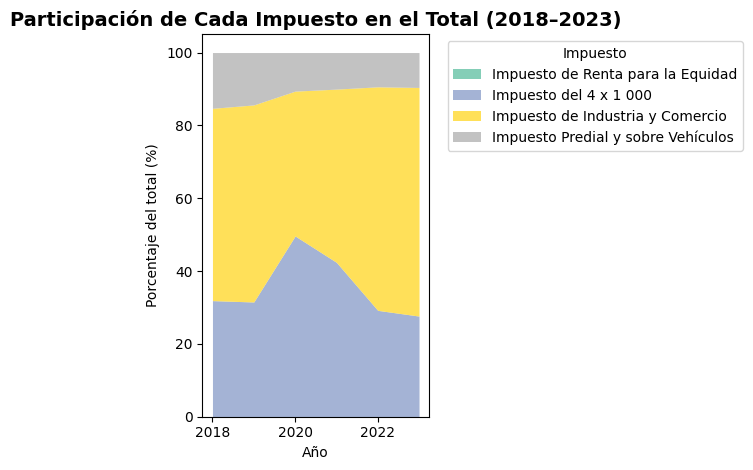

<Figure size 640x480 with 0 Axes>

In [ ]:
# 4) Participación relativa de cada impuesto por año
df_share = df_anual.div(df_anual.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8,5))
df_share.plot(kind='area', stacked=True, colormap='Set2', alpha=0.8, linewidth=0)
plt.title("Participación de Cada Impuesto en el Total (2018–2023)", fontsize=14, fontweight="bold")
plt.xlabel("Año")
plt.ylabel("Porcentaje del total (%)")
plt.legend(title="Impuesto", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

fig = plt.gcf()
fig.savefig("Grafico4_Boxplot_Recaudo.png", dpi=300, bbox_inches="tight", facecolor="white")


In [ ]:
# 5) distribución geográfica de recaudo, para ello:

# primero, calcular el total de impuestos por departamento
# segundo, identificar todas las columnas numéricas que NO sean 'dpto', 'AÑO' o 'TOTAL **'
tax_columns_to_sum = [col for col in df_EAM_impuestos.columns if col not in ['dpto', 'AÑO', 'TOTAL **'] and df_EAM_impuestos[col].dtype in [np.number, 'float64', 'int64']]

# tercero, sumar todos los impuestos para cada departamento y año, y luego sumar por departamento
df_total_impuestos_dpto = df_EAM_impuestos.groupby('dpto')[tax_columns_to_sum].sum().sum(axis=1).reset_index(name='Total_Impuestos')

# cuarto, para una mejor visualización en el mapa, escalamos los valores a miles de millones (Billones) COP
df_total_impuestos_dpto['Total_Impuestos_Billones'] = df_total_impuestos_dpto['Total_Impuestos'] / 1e9

print("Total de impuestos por departamento (Top 10):")
display(df_total_impuestos_dpto.sort_values(by='Total_Impuestos', ascending=False).head(10))

Total de impuestos por departamento (Top 10):


/tmp/ipython-input-564844081.py:5: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  tax_columns_to_sum = [col for col in df_EAM_impuestos.columns if col not in ['dpto', 'AÑO', 'TOTAL **'] and df_EAM_impuestos[col].dtype in [np.number, 'float64', 'int64']]


,dpto,Total_Impuestos,Total_Impuestos_Billones
2,11,5.181607e+11,518.160678
10,25,2.071785e+11,207.178478
23,76,1.189874e+11,118.987356
0,5,1.165075e+11,116.507523
1,8,3.679286e+10,36.792857
3,13,3.266990e+10,32.669896
20,68,1.645380e+10,16.453801
14,47,9.962592e+09,9.962592
19,66,7.811981e+09,7.811981
5,17,6.122186e+09,6.122186


Ahora, cargamos el archivo GeoJSON con `geopandas` y lo fusionamos con nuestros datos de impuestos para poder visualizarlo.

El código intentará cargar un archivo llamado `colombia_departamentos.geojson`. Si no lo encuentra, intentará descargarlo de una URL pública.

GeoJSON cargado exitosamente desde: https://raw.githubusercontent.com/caticoa3/colombia_mapa/master/co_2018_MGN_DPTO_POLITICO.geojson


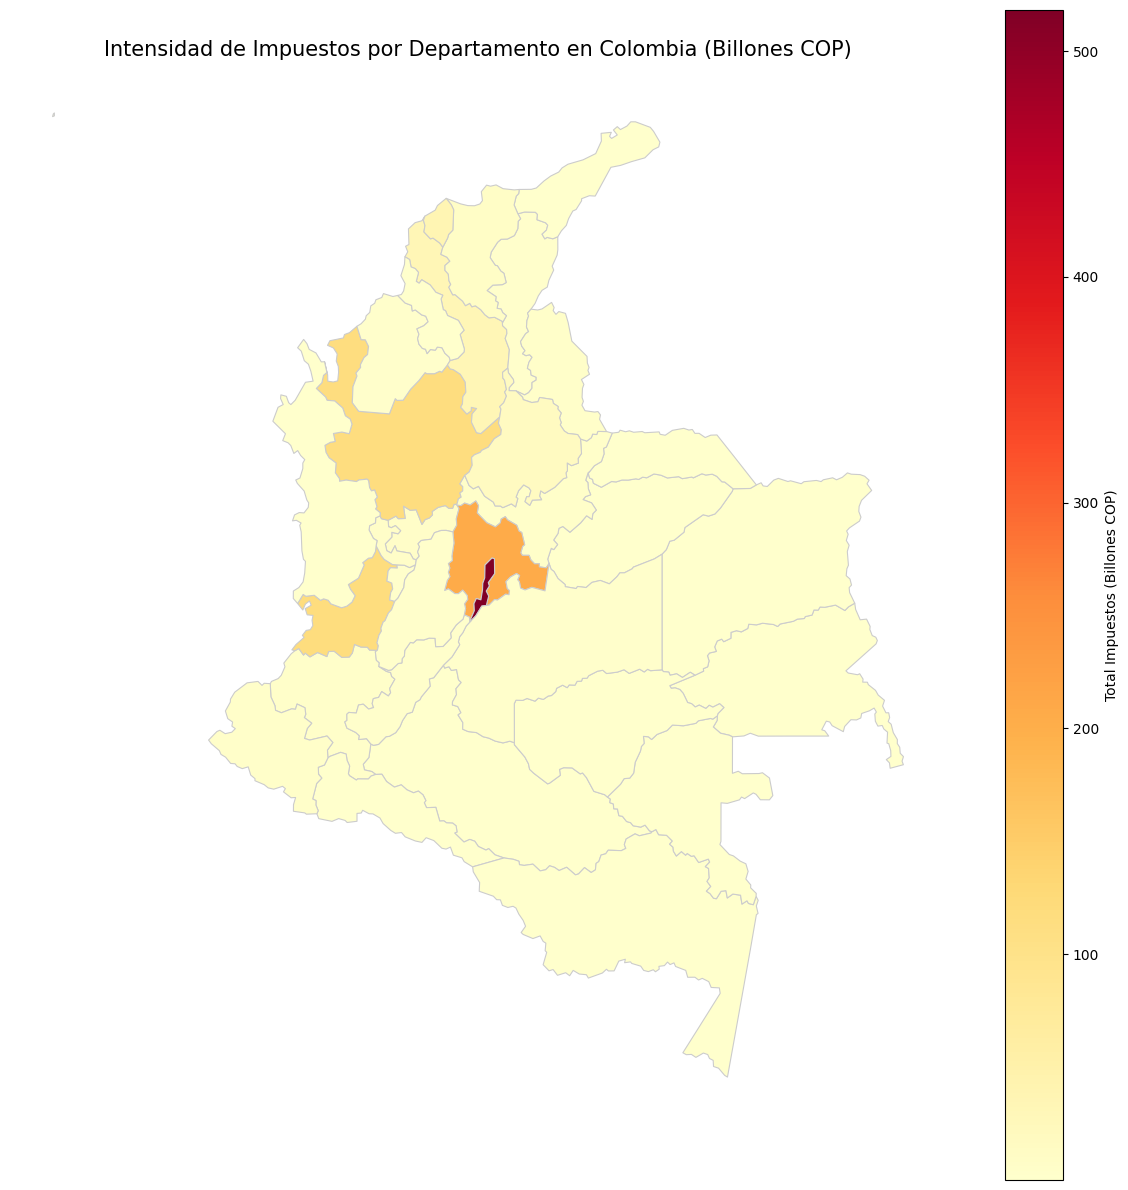

Mapa guardado como 'mapa_impuestos_departamentos_matplotlib.png'


In [ ]:
# 2. Cargar el GeoJSON de los departamentos de Colombia con geopandas
geojson_url = 'https://raw.githubusercontent.com/caticoa3/colombia_mapa/master/co_2018_MGN_DPTO_POLITICO.geojson'

try:
    gdf_colombia = gpd.read_file(geojson_url)
    print(f"GeoJSON cargado exitosamente desde: {geojson_url}")

except Exception as e:
    print(f"Error al cargar el GeoJSON desde la URL: {e}")
    gdf_colombia = None


if gdf_colombia is not None:
    # Asegurarse de que la columna de código de departamento en el GeoDataFrame sea numérica
    # La columna 'DPTO_CCDGO' o 'DPTO' es común para el código de departamento.
    if 'DPTO_CCDGO' in gdf_colombia.columns:
        gdf_colombia['dpto'] = pd.to_numeric(gdf_colombia['DPTO_CCDGO'], errors='coerce')
    elif 'DPTO' in gdf_colombia.columns:
        gdf_colombia['dpto'] = pd.to_numeric(gdf_colombia['DPTO'], errors='coerce')
    else:
        print("Advertencia: No se encontró una columna común para el código de departamento ('DPTO_CCDGO' o 'DPTO') en el GeoJSON.")
        print("Por favor, revisa las columnas de tu GeoJSON: ", gdf_colombia.columns.tolist())
        gdf_colombia['dpto'] = None # Para evitar errores en la siguiente fusión

    gdf_colombia = gdf_colombia.dropna(subset=['dpto'])
    gdf_colombia['dpto'] = gdf_colombia['dpto'].astype(int)

    # 3. Fusionar los datos de impuestos con el GeoDataFrame
    gdf_merged = gdf_colombia.merge(df_total_impuestos_dpto, on='dpto', how='left')
    gdf_merged['Total_Impuestos_Billones'] = gdf_merged['Total_Impuestos_Billones'].fillna(0) # Llenar NaN con 0 para departamentos sin datos

    # 4. Crear el mapa coroplético con matplotlib y geopandas
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    gdf_merged.plot(column='Total_Impuestos_Billones',
                    cmap='YlOrRd',
                    linewidth=0.8,
                    ax=ax,
                    edgecolor='0.8',
                    legend=True,
                    legend_kwds={'label': "Total Impuestos (Billones COP)"})

    ax.set_title('Intensidad de Impuestos por Departamento en Colombia (Billones COP)', fontsize=15)
    ax.set_axis_off() # Eliminar los ejes de coordenadas
    plt.tight_layout()
    plt.show()

    # Guardar el mapa como un archivo de imagen (opcional)
    map_filename = 'mapa_impuestos_departamentos_matplotlib.png'
    fig.savefig(map_filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Mapa guardado como '{map_filename}'")

else:
    print("No se pudo generar el mapa coroplético porque no se pudo obtener o cargar el GeoJSON.")

In [ ]:
# estandarizamos los datos del dataset que se generó con los datos de la EAM y la DIAN dejando solo los impuestos seleccionados.
scaler_impuestos = StandardScaler()
X_impuestos_scaled = scaler_impuestos.fit_transform(df_EAM_impuestos[columnas_impuestos])


## PCA

In [ ]:
# aplicamos pca a nuestros datos de los 4 impuestos estandarizados
pca_simple = PCA()
pca_simple.fit(X_impuestos_scaled)

PCA()

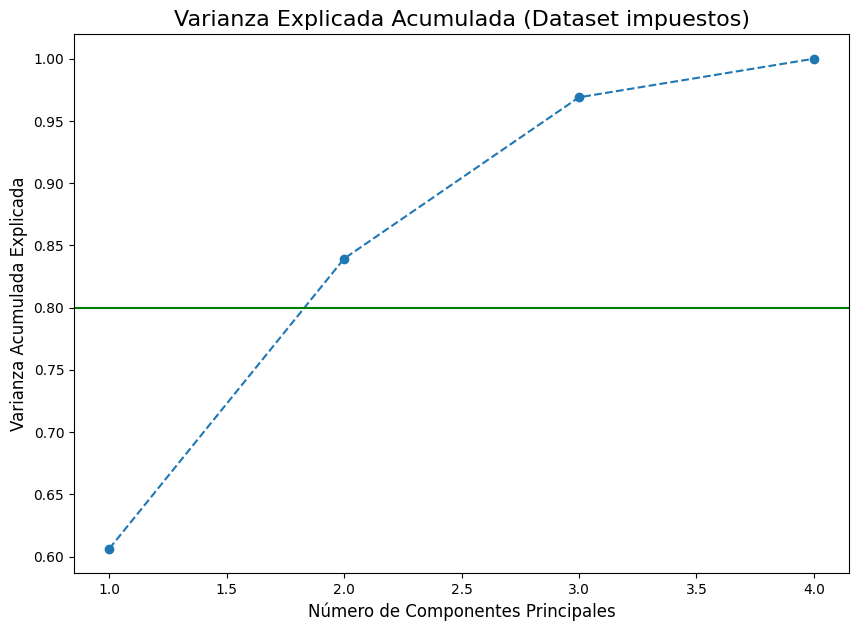

In [ ]:
# a través del metodo del codo veremos el número óptimo de compopnentes,
# para aprovechar PCA sin caer en componenetes que no incidan en la varianza
# esto permitirá tener la menor cantidad de componenetes y así aspirar a visualizar
# en pocas dimensiones los componentes.
varianza_acumulada_impuestos = np.cumsum(pca_simple.explained_variance_ratio_)

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(varianza_acumulada_impuestos) + 1), varianza_acumulada_impuestos, marker='o', linestyle='--')
plt.title('Varianza Explicada Acumulada (Dataset impuestos)', fontsize=16)
plt.xlabel('Número de Componentes Principales', fontsize=12)
plt.ylabel('Varianza Acumulada Explicada', fontsize=12)
plt.axhline(y=0.8, color='g', linestyle='-', label='80% de Varianza')
plt.show()

In [ ]:
#seleccionamos 2 componentes.
# notese que ahora las dimensiones se redujeron a dos:
pca_impuestos_2 = PCA(n_components=2)
X_impuestos_pca = pca_impuestos_2.fit_transform(X_impuestos_scaled)
print("Dimensiones del dataset original:", X_impuestos_scaled.shape)
print("Dimensiones del dataset reducido:", X_impuestos_pca.shape)

Dimensiones del dataset original: (198, 4)
Dimensiones del dataset reducido: (198, 2)


In [ ]:
# Varianza explicada
pca_impuestos_2.explained_variance_ratio_


array([0.60628065, 0.23306127])

In [ ]:
# varianza explicada acumulado
pca_impuestos_2.explained_variance_ratio_.cumsum()

array([0.60628065, 0.83934192])

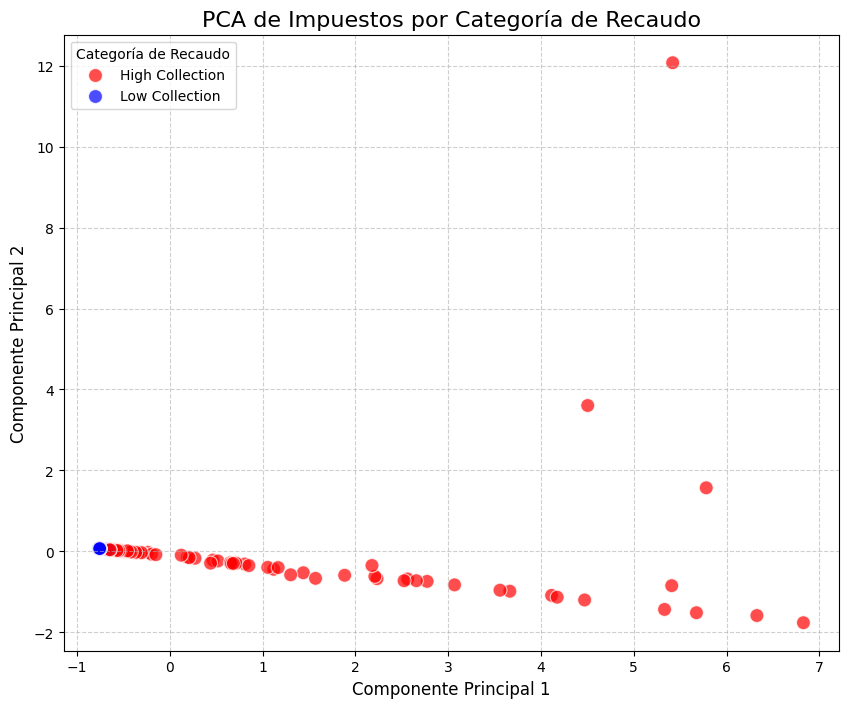

In [ ]:
# graficamos los componentes:
# Create df_impuestos_pca from the previously computed X_impuestos_pca (NumPy array)
df_impuestos_pca = pd.DataFrame(data=X_impuestos_pca, columns=['CP1', 'CP2'])

median_cp1 = df_impuestos_pca['CP1'].median()
df_impuestos_pca['Collection_Category'] = df_impuestos_pca['CP1'].apply(
    lambda x: 'High Collection' if x > median_cp1 else 'Low Collection'
)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='CP1',
    y='CP2',
    hue='Collection_Category',
    data=df_impuestos_pca,
    palette={'High Collection': 'red', 'Low Collection': 'blue'},
    s=100,
    alpha=0.7
)
plt.title('PCA de Impuestos por Categoría de Recaudo', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Categoría de Recaudo')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

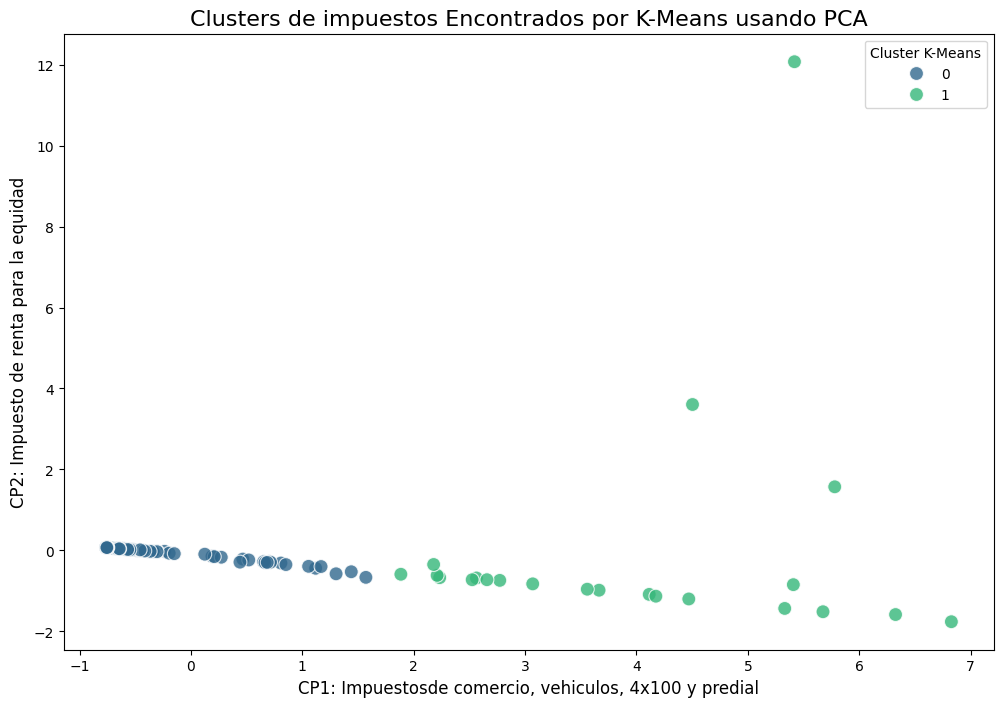

In [ ]:
# Instanciamos KMeans pidiendo 2 clusters, (de dos componentes principales)
kmeans_impuestos = KMeans(n_clusters=2, random_state=42, n_init=10)

# Ajustamos y predecimos sobre los datos PCA (X_wine_pca tiene CP1 y CP2)
df_impuestos_pca['Cluster_KMeans'] = kmeans_impuestos.fit_predict(X_impuestos_pca)

# Visualizamos los clusters encontrados por K-Means
plt.figure(figsize=(12, 8))
sns.scatterplot(x='CP1', y='CP2', data=df_impuestos_pca, hue='Cluster_KMeans', palette='viridis', s=100, alpha=0.8)
plt.title('Clusters de impuestos Encontrados por K-Means usando PCA', fontsize=16)
plt.xlabel('CP1: Impuestosde comercio, vehiculos, 4x100 y predial', fontsize=12)
plt.ylabel('CP2: Impuesto de renta para la equidad', fontsize=12)
plt.legend(title='Cluster K-Means')
plt.show()

In [ ]:
# descripción de componentes prncipales:
df_impuestos_loadings = pd.DataFrame(pca_impuestos_2.components_,
                                columns=columnas_impuestos,
                                index=['CP1', 'CP2'])
df_impuestos_loadings

,Impuesto de Renta para la Equidad,Impuesto del 4 x 1 000,Impuesto de Industria y Comercio,Impuesto Predial y sobre Vehículos
CP1,0.221542,0.504757,0.595143,0.584760
CP2,0.970077,-0.038703,-0.202901,-0.127611
